# Imports

In [1]:
import os
import time
import random
import numpy as np

import tensorflow as tf
import tensorflow.contrib.layers as layers

import gym
from gym import spaces
from PIL import Image
from collections import deque, namedtuple
from atari_wrappers import wrap_deepmind

from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

# Network class

In [2]:
class DistributionalQNetwork:
    
    def __init__(self, num_actions, state_shape=[84, 84, 4],
                 convs=[[32, 8, 4], [64, 4, 2], [64, 3, 1]], 
                 fully_connected=[512], num_atoms=21, v=(-10, 10),
                 optimizer = tf.train.AdamOptimizer(2.5e-4),
                 scope="q_network", reuse=False):
        """Class for neural network which estimates Q-function
        
        Parameters
        ----------
        num_actions: int
            number of actions the agent can take
        state_shape: list
            list of 3 parameters [frame_w, frame_h, num_frames]
            frame_w: frame width
            frame_h: frame height
            num_frames: number of successive frames considered as a state
        conv: list
            list of convolutional layers' parameters, each element
            has the form -- [num_outputs, kernel_size, stride]
        fully_connected: list
            list of fully connected layers' parameters, each element
            has the form -- num_outputs 
        num_atoms: int
            number of atoms in distribution support
        v: tuple
            tuple of 2 parameters (v_min, v_max)
            v_min: minimum q-function value
            v_max: maximum q-function value    
        optimizer: tf.train optimizer
            optimization algorithm for stochastic gradient descend
        scope: str
            unique name of a specific network
        """
        
        xavier = layers.xavier_initializer()
        
        ###################### Neural network architecture ######################
        
        input_shape = [None] + state_shape
        self.input_states = tf.placeholder(dtype=tf.float32, shape=input_shape)
        
        # discrete distribution parameters
        self.num_atoms = num_atoms
        self.v_min, self.v_max = v
        self.delta_z = (self.v_max - self.v_min) / (self.num_atoms - 1)
        self.z = [self.v_min + i * self.delta_z for i in range(self.num_atoms)]   
        
        with tf.variable_scope(scope, reuse=reuse):
            # convolutional part of the network
            conv_layers = [self.input_states]
            with tf.variable_scope("conv"):
                for num_outputs, kernel_size, stride in convs:
                    conv = layers.convolution2d(conv_layers[-1], 
                                                num_outputs=num_outputs,
                                                kernel_size = kernel_size,
                                                stride=stride,
                                                padding='VALID',
                                                biases_initializer=None,
                                                activation_fn=tf.nn.relu)
                    conv_layers.append(conv)
                self.conv_layers = conv_layers[1:]
            self.conv_out = layers.flatten(self.conv_layers[-1])

            # fully connected part of the network
            fc_layers = [self.conv_out]
            with tf.variable_scope("fc"):
                for num_outputs in fully_connected:
                    fc = layers.fully_connected(fc_layers[-1],
                                                num_outputs=num_outputs,
                                                activation_fn=tf.nn.relu,
                                                biases_initializer=None,
                                                weights_initializer=xavier)
                    fc_layers.append(fc)
                self.fc_layers = fc_layers[1:]
            self.fc_out = self.fc_layers[-1]
            
            # probabilities of atoms
            self.action_probs = []
            with tf.variable_scope("actions"):
                for action in range(num_actions):
                    action_layer = layers.fully_connected(self.fc_out,
                                                          num_outputs=self.num_atoms,
                                                          activation_fn=None,
                                                          biases_initializer=None,
                                                          weights_initializer=xavier)
                    action_prob = tf.nn.softmax(action_layer)
                    self.action_probs.append(action_prob)
                self.state_probs = tf.stack(self.action_probs, axis=1)

            # q-values as expectations
            with tf.variable_scope("q_values"):
                q_values = []
                for action in range(num_actions):
                    q_value = tf.reduce_sum(self.z * self.action_probs[action])
                    q_value = tf.reshape(q_value, [-1, 1])
                    q_values.append(q_value)
                self.q_state_values = tf.concat(q_values, axis=1)

                                                               
        ######################### Optimization procedure ########################
        
        # Q-function approximation
        self.input_actions = tf.placeholder(dtype=tf.int32, shape=[None])
        actions_onehot = tf.one_hot(self.input_actions, num_actions, dtype=tf.float32)
        
        q_values_selected = tf.multiply(self.q_state_values, actions_onehot)
        self.q_action_values = tf.reduce_sum(q_values_selected, axis=1)
        self.q_max_values = tf.argmax(self.q_state_values, axis=1)
        
        actions_onehot_= tf.reshape(actions_onehot, [-1, num_actions, 1])
        self.probs_selected = tf.reduce_sum(tf.multiply(self.state_probs, actions_onehot_), axis=1)
  
        self.input_m = tf.placeholder(dtype=tf.float32, shape=[None, self.num_atoms])
        
        # construct loss function and optimizer
        
        self.loss = -tf.reduce_sum(self.input_m * tf.log(self.probs_selected))
        
        self.optimizer = optimizer
        self.update_model = self.optimizer.minimize(self.loss)
        
    
    def cat_proj(self, sess, rewards, states_, actions_, end, gamma=0.99):
        
        feed_dict = {self.input_states:states_, self.input_actions:actions_}
        probs = sess.run(self.probs_selected, feed_dict=feed_dict)
        m = np.zeros_like(probs)
        rewards = np.array(rewards, dtype=np.float32)
        end = np.array(end, dtype=np.float32)
        batch_size = rewards.size
        
        for j in range(self.num_atoms):

            Tz = rewards + gamma * end * self.z[j]
            Tz = np.minimum(self.v_max, np.maximum(self.v_min, Tz))
            b = (Tz - self.v_min) / self.delta_z
            l = np.floor(b)
            u = np.ceil(b)
            
            m[np.arange(batch_size), l.astype(int)] += probs[:,j] * (u - b)
            m[np.arange(batch_size), u.astype(int)] += probs[:,j] * (b - l) 
        return m 
            
    
    def argmax_q(self, sess, states):
        feed_dict = {self.input_states:states}
        q_max_values = sess.run(self.q_max_values, feed_dict)
        return q_max_values

    def q_values(self, sess, states):
        feed_dict = {self.input_states:states}
        q_state_values = sess.run(self.q_state_values, feed_dict)
        return q_state_values

    def update(self, sess, states, actions, input_m):
        
        feed_dict = {self.input_states:states,
                     self.input_actions:actions,
                     self.input_m:input_m}
        
        sess.run(self.update_model, feed_dict)

# Experience replay class

In [3]:
class ReplayMemory:

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        self.transition = namedtuple('Transition', 
                                     ('s', 'a', 'r', 's_', 'end'))

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = [*args]
        self.position = (self.position + 1) % self.capacity
    
    def get_batch(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        batch = np.reshape(batch, [batch_size, 5])
        s = np.stack(batch[:,0])
        a = batch[:,1]
        r = batch[:,2]
        s_ = np.stack(batch[:,3])
        end = 1 - batch[:,4]
        return self.transition(s, a, r, s_, end)

    def __len__(self):
        return len(self.memory)

# Agent for playing Atari

In [4]:
class AtariAgent:
    
    def __init__(self, game_id, num_actions=None, model_name="baseline_agent"):
        """Class for training and evaluating DQN agent on Atari games
        
        Parameters
        ----------
        game_id: str
            game identifier in gym environment, e.g. "Pong"
        num_actions: int
            number of actions the agent can take
        model_name: str
            name of the model
        """
        
        ############################ Game environment ############################
        
        self.game_id = game_id + "NoFrameskip-v4"
        self.train_env = wrap_deepmind(gym.make(self.game_id))
        self.test_env = wrap_deepmind(gym.make(self.game_id), clip_rewards=False)
        
        if num_actions is None:
            self.num_actions = self.train_env.unwrapped.action_space.n
        else:
            self.num_actions = num_actions
            
        self.path = "./" + game_id + "/" + model_name
        if not os.path.exists(self.path):
            os.makedirs(self.path)
        
        ############################# Agent & Target #############################
        
        tf.reset_default_graph()
        self.agent_net = DistributionalQNetwork(self.num_actions, scope="agent")
        self.target_net = DistributionalQNetwork(self.num_actions, scope="target")
        
        self.init = tf.global_variables_initializer()
        self.saver = tf.train.Saver()
        
        all_vars = tf.trainable_variables()
        num_vars = len(all_vars) // 2
        self.agent_vars = all_vars[:num_vars]
        self.target_vars = all_vars[num_vars:]
        
    def set_parameters(self, 
                       replay_memory_size=50000,
                       replay_start_size=10000,
                       init_eps=1,
                       final_eps=0.1,
                       annealing_steps=1000000,
                       discount_factor=0.99,
                       max_episode_length=2000):
        
        self.rep_buffer = ReplayMemory(replay_memory_size)
        frame_count = 0
        while (frame_count < replay_start_size):
            s = self.train_env.reset()   
            for time_step in range(max_episode_length):
                a = np.random.randint(self.num_actions)
                s_, r, end, info = self.train_env.step(a)
                self.rep_buffer.push(s, a, r, s_, end)
                s = s_
                frame_count += 1
                if end:
                    if self.train_env.unwrapped.ale.lives() == 0: break
                    else: s = self.train_env.reset()
                        
        self.eps = init_eps
        self.final_eps = final_eps
        self.eps_drop = (init_eps - final_eps) / annealing_steps
        self.gamma = discount_factor
        self.max_ep_length = max_episode_length
        
    def train(self,
              gpu_id=0,
              batch_size=32,
              agent_update_freq=4,
              target_update_freq=5000,
              tau=1,
              num_episodes=100000,
              model_save_freq=500,
              learning_curve_save_freq=100,
              performance_print_freq=100,
              model_test_freq=50000,
              test_episodes_num=10):
        
        os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
        os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        
        target_ops = self.update_target_graph(tau)
        
        with tf.Session(config=config) as sess:
            sess.run(self.init)
            frame_count = 0
            test_freq_threshold = 1
            
            train_rewards = []
            test_rewards = []
            frame_counts = []
            
            for i in range(num_episodes):
                s = self.train_env.reset()
                train_ep_reward = 0
                
                for time_step in range(self.max_ep_length):
                    
                    if np.random.rand(1) < self.eps:
                        a = np.random.randint(self.num_actions)
                    else:
                        a = self.agent_net.argmax_q(sess, [s])
                    s_, r, end, info = self.train_env.step(a)
                    self.rep_buffer.push(s, a, r, s_, end)
                    s = s_
                    frame_count += 1
                    train_ep_reward += r
                    
                    if self.eps > self.final_eps:
                        self.eps -= self.eps_drop
                        
                    if frame_count % agent_update_freq == 0:
                        
                        batch = self.rep_buffer.get_batch(batch_size)
                        
                        max_actions = self.agent_net.argmax_q(sess, batch.s_)
                        target_m = self.target_net.cat_proj(sess, batch.r, batch.s_, 
                                                            max_actions, batch.end)
                        self.agent_net.update(sess, batch.s, batch.a, target_m)
                        
                        if tau == 1:
                            if frame_count % target_update_freq == 0:
                                self.update_target_weights(sess, target_ops)
                        else: self.update_target_weights(sess, target_ops)
                            
                    if end: 
                        if self.train_env.unwrapped.ale.lives() == 0: break
                        else: s = self.train_env.reset()
                
                train_rewards.append(train_ep_reward)

                if i % model_save_freq == 0:
                    self.saver.save(sess, self.path+"/model-"+str(i)+".ckpt")
                    print("Model saved.")

                # periodically save the learning curve
                if i % learning_curve_save_freq == 0:
                    np.savez(self.path+"/learning_curve.npz", r=train_rewards)

                # periodically print model performance
                if i % performance_print_freq == 0:
                    avg_reward = np.mean(train_rewards[-performance_print_freq:])
                    print("Train info:", frame_count, avg_reward, self.eps)

                # periodicaly test greedy policy derived from the model
                if frame_count // test_freq_threshold > 0:
                    test_freq_threshold += model_test_freq
                    one_test_rewards = []

                    for j in range(test_episodes_num):
                        test_ep_reward = 0
                        s = self.test_env.reset()
                        for time_step in range(self.max_ep_length):
                            a = self.agent_net.argmax_q(sess, [s])
                            s, r, end, info = self.test_env.step(a)
                            test_ep_reward += r
                            if end: 
                                if self.test_env.unwrapped.ale.lives() == 0: break
                                else: s = self.test_env.reset()
                        one_test_rewards.append(test_ep_reward)

                    avg_reward = sum(one_test_rewards[-test_episodes_num:]) / test_episodes_num
                    frame_counts.append(frame_count)
                    test_rewards.append(one_test_rewards)

                    print("Test info:", frame_count, avg_reward)
                    np.savez(self.path+'/test_curve.npz', frames=frame_counts, r=test_rewards)            

    def update_target_graph(self, tau):
        op_holder = []
        for agnt, trgt in zip(self.agent_vars, self.target_vars):
            op = trgt.assign(agnt.value()*tau + (1 - tau)*trgt.value())
            op_holder.append(op)
        return op_holder

    def update_target_weights(self, sess, op_holder):
        for op in op_holder:
            sess.run(op)

# Train

In [5]:
aa = AtariAgent("Breakout", model_name="baseline_distributional")

[2017-10-19 12:53:31,962] Making new env: BreakoutNoFrameskip-v4
[2017-10-19 12:53:32,265] Making new env: BreakoutNoFrameskip-v4


In [ ]:
aa.set_parameters(max_episode_length=5000, replay_memory_size=100000, replay_start_size=50000)

In [ ]:
aa.train(gpu_id=0)

# Performace visualization

In [6]:
def plot_average(r, tau):
    r_mat = np.resize(np.array(r),[len(r)//tau, tau])
    r_mean = np.average(r_mat, axis=1)
    return np.arange(tau, (r_mean.size+1)*tau, tau), r_mean

def plot_performance(path, tau=20, eta=20, avg=True, best=False, worst=False):
    
    r_train = np.load(path + "/learning_curve.npz")["r"]
    r_test = np.load(path + "/test_curve.npz")['r']
    frames = np.load(path + "/test_curve.npz")['frames']
    coef = frames[-1]/1000000

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    x, y = plot_average(r_train, tau)
    ax[0].plot(x, y)
    ax[0].grid()
    
    if avg:
        x, y = plot_average(r_test.mean(axis=1), eta)
        x = x / x.max()
        x = x*coef
        ax[1].plot(x, y)
    if best:
        x, y = plot_average(r_test.max(axis=1), eta)
        x = x / x.max()
        x = x*coef
        ax[1].plot(x, y)
    if worst:
        x, y = plot_average(r_test.min(axis=1), eta)
        x = x / x.max()
        x = x*coef
        ax[1].plot(x, y)
    ax[1].grid()

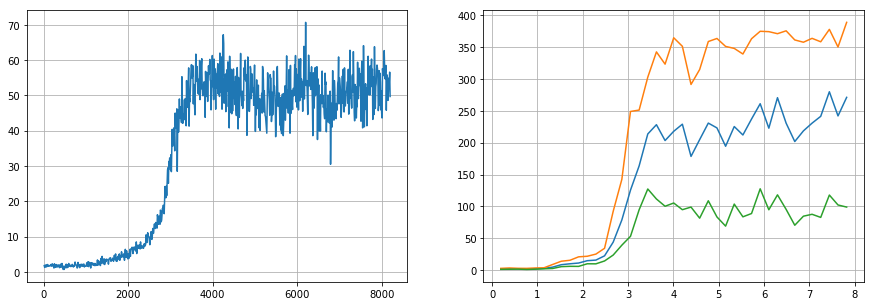

In [7]:
path = "Breakout/baseline_distributional/"
plot_performance(path, tau=10, eta=10, best=True, worst=True)